In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
import datetime
import glob
import pandas as pd
from sklearn.linear_model import LogisticRegression
%matplotlib inline

daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)
plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')

/home/brad/DailyLog/20200105/


In [2]:
f_fam_orig = '/home/brad/DailyLog/20200105/JSpop_fast_B1083Combined-1-1-20_LvsR-fam-orig.pkl'
f_fam_shuff = '/home/brad/DailyLog/20200105/JSpop_fast_B1083Combined-1-1-20_LvsR-fam-shuff.pkl'

In [9]:
# cond: -1 = different, 1 = same class

def extract_submatrix(mat, h, pos):
    x, y = pos
    return mat[x*h:(x+1)*h, y*h:(y+1)*h].flatten()


def build_lmm_dataset(div_matrix):
    n, _ = np.shape(div_matrix)
    h = int(n/8)
    
    LR_mask = np.zeros((n, n))
    LR_mask[0:2*h, 2*h:4*h] = 1
    LR_mask[2*h:4*h, 4*h:6*h] = 1
    LR_mask[0:2*h, 6*h:n] = 1
    LR_mask[4*h:6*h, 6*h:n] = 1
    LR_inds = np.nonzero(LR_mask)
    LR_data_full = div_matrix[LR_inds]
    LR_data = np.random.choice(LR_data_full, size=12*h*h)
    print(LR_data.shape)
    LR_condition = 12*h*h*['different']

    
    LL_blocks = [(0,1), (0,4), (0,5), (1,4), (1,5), (4,5)]
    RR_blocks = [(2,3), (2,6), (2,7), (3,6), (3,7), (6,7)]
    
    #LL_data = div_matrix[0:h, h:2*h].flatten()
    
    LL_data = np.concatenate(list(map(lambda pos: extract_submatrix(div_matrix, h, pos), LL_blocks)))
    LL_condition = len(LL_data)*['same']

    RR_data = np.concatenate(list(map(lambda pos: extract_submatrix(div_matrix, h, pos), RR_blocks)))
    #RR_data = div_matrix[2*h:3*h, 3*h:n].flatten()

    RR_condition = len(RR_data)*['same']

    
    dat_cat = np.concatenate((LL_data, LR_data.flatten(), RR_data))

    cond_cat = np.concatenate((LL_condition, LR_condition, RR_condition))
    
    df_out = pd.DataFrame(data={'JS': dat_cat,'cond': cond_cat})
    return df_out


def build_LRpredict_dataset(div_matrix):
    n, _ = div_matrix.shape
    print(n)
    LR_classes = np.concatenate([int(n/2)*['L'], int(n/2)*['R']])
    featmat = np.zeros((n, n-1))
    for trial in range(n):
        trialdat = div_matrix[trial, :]
        trialdat = np.concatenate([trialdat[0:trial], trialdat[trial+1:]])
        featmat[trial, :] = trialdat
    return (LR_classes, featmat)
    
    
def grouped_boxplot_with_scatter(data, order, ngroups=1, group_spacing=2, fig_path=None, colors=None, alphas=None, labels=None, positions=None, scatter_style=None, marker_size = 1, figsize=(5,4)):
    ''' From Zeke 
        Plot grouped boxplots
        data is in the form of a list of arrays, Ngroups*nboxes/group
    
    '''
    #colors = np.array(['pink', 'lightblue', 'lightgreen', 'pink', 'lightblue', 'lightgreen'])
    #alphas = np.array([0.25, 0.25, 0.25, 0.75, 0.75, 0.75])
    #labels = np.array(['CON/BOS', 'CON/Mot-wise', 'CON/Pc-wise', 'BOS/BOS', 'BOS/Mot-wise', 'BOS/Pc-wise'])
   
    nboxes = len(data)
    if alphas is None:
        alphas = np.array(nboxes*[1.0])
        
    dat_plot = [data[i] for i in order]
    
    # compute positions
    nboxes_per_group = int(int(len(data)) / int(ngroups))
    positions = np.arange(nboxes_per_group) +1
    for group in range(1, ngroups):
        positions = np.concatenate([positions, np.arange(max(positions)+group_spacing, max(positions)+group_spacing+nboxes_per_group)])
        
    
    box_plot_fig = plt.figure(figsize=figsize)
    ax = box_plot_fig.add_subplot(111)
    
    medianprops = dict(color='black')
    if positions is not None:
        box_plot = ax.boxplot(dat_plot, 0, '', positions=positions, patch_artist=False, whis='range', widths=1,
                              medianprops=medianprops)
        xlim1 = max(positions)+1
    else:
        box_plot = ax.boxplot(dat_plot, 0, '', patch_artist=False, whis='range', widths=1, medianprops=medianprops)
        xlim1 = max(order)+1

        
    # Do scatter
    scatter_plots = []
    
    for i in order:
        xs = np.array(len(data[i])*[positions[i]])+0.1*np.random.randn(len(data[i]))
        if scatter_style is None:
            scatter_plot = ax.scatter(xs, data[i], s=marker_size, alpha=1) 
        else:
            scatter_plot = ax.scatter(xs, data[i], s=marker_size, alpha=1, marker=scatter_style[i])
        scatter_plots.append(scatter_plot)
        
    # Compute group label positions
    labelpos =[]
    for group in range(ngroups):
        pos = positions[group*(nboxes_per_group):group*(nboxes_per_group)+nboxes_per_group]
        labelpos.append(np.mean(pos))
    
    plt.xticks(labelpos, labels, rotation=0)
    plt.grid(False)
    plt.ylim(0.0, 1)
    plt.xlim(0.0, xlim1)
    ax.tick_params(axis='both', labelsize=18)
    if colors is not None:
        for patch, color, alpha in zip(scatter_plots, colors[order], alphas[order]):
                patch.set_facecolor(color)
                #patch.set_alpha(0.0)
    
    #label_diff(1, 2, '**', dat_plot[0], dat_plot[1], ax)
    #plt.savefig(fig_path)
    return (box_plot_fig, positions)

def label_diff(i,j,text,X,Y, ax):
    x = (X[i]+X[j])/2.0
    y = 1.01*max(max(Y[i]), max(Y[j]))
    dx = abs(X[i]-X[j])
    print(x, y, dx)
    props = {'connectionstyle':'bar','arrowstyle':'-',
                 'shrinkA':50,'shrinkB':50,'linewidth':1}
    #props = {'connectionstyle':'bar','arrowstyle':'-','linewidth':1}
    ax.annotate(text, xy=(X[i], y), zorder=10)
    ax.annotate('', xy=(X[i],y), xytext=(X[j],y), arrowprops=props)
    print(X[j], y)
    
from matplotlib.markers import TICKDOWN
def significance_bar(start,end,height,displaystring, stringheightfactor=1.0075, linewidth = 1.2,markersize = 8,boxpad  =0.3,fontsize = 15,color = 'k'):
    # draw a line with downticks at the ends
    plt.plot([start,end],[height]*2,'-',color = color,lw=linewidth,marker = TICKDOWN,markeredgewidth=linewidth,markersize = markersize)
    # draw the text with a bounding box covering up the line
    plt.text(0.5*(start+end),stringheightfactor*height,displaystring,ha = 'center',va='center',size = fontsize)
    #bbox=dict(facecolor='1.', edgecolor='none',boxstyle='Square,pad='+str(boxpad))


In [10]:
with open(f_fam_orig, 'rb') as f:
    div = pickle.load(f)
    
with open(f_fam_shuff, 'rb') as f:
    divs = pickle.load(f)
    


In [15]:
dataset = build_lmm_dataset(div)
dataset_s = build_lmm_dataset(divs)


(4800,)
(4800,)


In [16]:
csss = [dataset, dataset_s]
scsv = []
from tqdm import tqdm
for ds in tqdm(csss):
    
    N_tests = 240
    train_pct = 0.8
    test_pct = 1 - train_pct
    targ = ds['cond'].values
    feat = ds['JS'].values
    scores = []
    for test in range(N_tests):
        ntarg = int(train_pct*len(targ))
        perm = np.random.permutation(np.arange(len(targ)))
        targ_train = targ[perm[0:ntarg]]
        feat_train = feat[perm[0:ntarg]][:, np.newaxis]
        targ_test = targ[perm[ntarg:]]
        feat_test = feat[perm[ntarg:]][:, np.newaxis]
        lr = LogisticRegression()
        lr.fit(feat_train, targ_train)
        
        scores.append(lr.score(feat_test, targ_test))
    scsv.append(scores)

100%|██████████| 2/2 [00:12<00:00,  6.28s/it]


TypeError: list indices must be integers or slices, not range

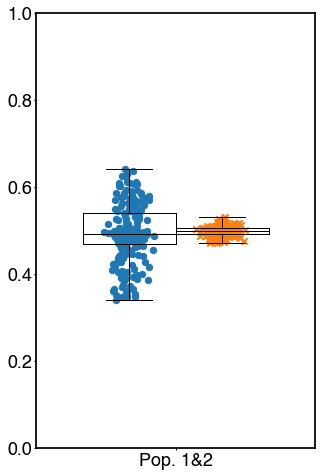

In [20]:

colors = ['#111111', '#111111']
marker_style = ['o', 'x']
(fig, pos) = grouped_boxplot_with_scatter(scsv, order=range(2), ngroups=1, labels=['Pop. 1&2'], colors=colors, scatter_style=marker_style, figsize=(5,8), marker_size=40)


significance_bar(pos[0],pos[1], 0.97 , '***',linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')
significance_bar(pos[0], pos[2], 1.03, '***', linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')
significance_bar(pos[2], pos[3], 0.97, '***', linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')

significance_bar(pos[4],pos[5], 0.97 , '***',linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')
significance_bar(pos[4], pos[6], 1.03, '***',  linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')
significance_bar(pos[6], pos[7], 0.97, '***', linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')
plt.ylim([0.30, 1.1])

plt.savefig(os.path.join(figsavepth, 'B1083_Combined_JSDIVSTATS.pdf'.format(correlation_type)))

In [ ]:
pos[4]

In [18]:
from scipy.stats import ttest_ind
ttests =[(0,1)]
ttest_names = ['Pop1JS-Shuffle']
for t, n in zip(ttests, ttest_names):
    res = ttest_ind(scsv[t[0]], scsv[t[1]])
    print('TEST: {}'.format(n))
    print(res)


TEST: Pop1JS-Shuffle
Ttest_indResult(statistic=-1.3630134934337998, pvalue=0.1735199689894765)


In [ ]:
ttest_ind(scsv[4], scsv[5])

In [ ]:
lr.get_params()

In [ ]:
test = build_LRpredict_dataset(div2+div2.T)
tests = build_LRpredict_dataset(divs2+divs2.T)

In [ ]:
N_tests = 120
train_pct = 0.8
test_pct = 1 - train_pct
targ = test[0]
feat = test[1]
targs = tests[0]
feats = tests[1]
scores = []
scores_s = []
for test in range(N_tests):
    ntarg = int(train_pct*len(targ))
    perm = np.random.permutation(np.arange(len(targ)))
    targ_train = targ[perm[0:ntarg]]
    feat_train = feat[perm[0:ntarg],:]
    targ_test = targ[perm[ntarg:]]
    feat_test = feat[perm[ntarg:], :]
    lr = LogisticRegression()
    lr.fit(feat_train, targ_train)
    
    perms = np.random.permutation(np.arange(len(targ)))
    targs_train = targs[perms[0:ntarg]]
    feats_train = feats[perms[0:ntarg],:]
    targs_test = targs[perms[ntarg:]]
    feats_test = feats[perms[ntarg:], :]
    lrs = LogisticRegression()
    lrs.fit(feat_train, targ_train)
    
    scores.append(lr.score(feat_test, targ_test))
    scores_s.append(lrs.score(feats_test, targs_test))

In [ ]:
plt.boxplot([scores, scores_s])

In [ ]:
scores

In [ ]:
scores_s